In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 80
# BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [120]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)

def get_radnom_normal_indices(dataset, train_and_validation, amount=fraud_indices.shape[0]):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, amount, replace=False))
    return dataset.iloc[random_normal_indices, :].sample(frac=1)

def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [28]:
# Read CSV
#dataset = pd.read_csv(DATASET_NAME)
dataset = pd.read_csv("research/creditcard.csv")

assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

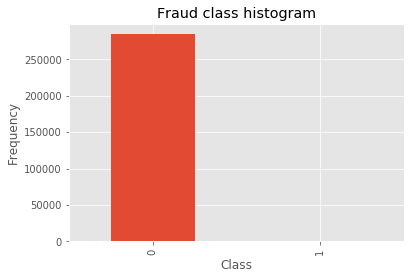

0    284315
1       492
Name: Class, dtype: int64

In [29]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [30]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = split_data(dataset, train_size=0.8)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [31]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


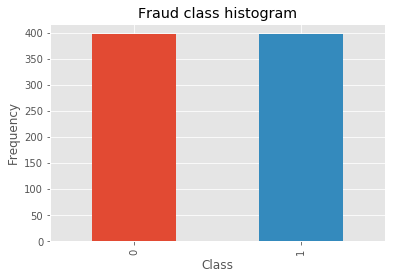

0    397
1    397
Name: Class, dtype: int64

In [32]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [33]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [35]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)

        print("Loss: ", train_loss)
        print("Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))

    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        
        for i in range(self.epochs):
            # zeby w kazdej epoce byly inne dobre i te same zle ( w jednej walidacji oczywiscie)
            
            
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.BIG_DELTAS = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [129]:
KFOLDS = 5

#Create array with only bad transactions for test&validation
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
fraud_indices = dataset.iloc[fraud_indices, :].sample(frac=1)
fraud_indices = fraud_indices.values

kfold_split_frauds = k_fold_split_data(fraud_indices, KFOLDS)

kfold_split_frauds_lens = [len(x) for x in kfold_split_frauds]
print(kfold_split_frauds_lens)

#Create array with only good transations for test&validation - EPOCHS times larger than fraud_indices
random_normal_test_amount = [(fraud_indices.shape[0]-kfold_split_frauds_lens[x])*EPOCHS for x in range(KFOLDS)]
random_normal_validation_amount = [kfold_split_frauds_lens[x] for x in range(KFOLDS)]
print(random_normal_test_amount)
print(random_normal_validation_amount)
random_normal_total_amount = sum(random_normal_test_amount) + sum(random_normal_validation_amount)
random_normal_indices = get_radnom_normal_indices(dataset, train_and_validation, amount=random_normal_total_amount)
random_normal_indices = random_normal_indices.values

print(random_normal_indices.shape)

# generate indices for all 5 normal validation sets
print("ile", fraud_indices.shape[0])
total_validation_normal_ind = np.random.randint(low = 0, high = random_normal_indices.shape[0],\
                                               size = sum(random_normal_validation_amount))

# [80 numbers, 80 numbers, 79, 79, 79]
total_validation_normal_ind_split = np.array_split(total_validation_normal_ind, 5) 

total_test_normal_ind = np.delete(arr = np.arange(random_normal_total_amount), obj = total_validation_normal_ind, axis = 0)
print("SIZES: ", total_test_normal_ind.shape[0], total_validation_normal_ind.shape[0], total_test_normal_ind.shape[0]+total_validation_normal_ind.shape[0], random_normal_total_amount)
"""
#generate 5 random numbers - indices of 5 normal validation sets (out of 81)
rand_validation_n_i = np.random.randint(low = 0, high = EPOCHS+1, size = 5)
print(rand_validation_n_i)
"""
SEGMENT_SIZE = len(fraud_indices)
print("SEGMENT_SIZE:", SEGMENT_SIZE)

# k-fold validation with k=5
models = []

[80, 80, 79, 79, 79]

[25360, 25360, 25440, 25440, 25440]

[80, 80, 79, 79, 79]

(127437, 29)

ile

397

SIZES: 

127041

397

127438

127437

SEGMENT_SIZE:

397

In [112]:
for k, validation_frauds in enumerate(kfold_split_frauds):
    #print(k_fold_split_array)
    #losowanie dobrych transakcji
    
    """
    normal_indices_split_array = k_fold_split_data(random_normal_indices, 5)
    validation_normal_indices = normal_indices_split_array.pop(n)
    normal_indices_split_array = np.concatenate(normal_indices_split_array)"""

    #Get train frauds from train&validation frauds
    train_frauds = kfold_split_frauds.copy()
    train_frauds.pop(k)
    #print(len(train_frauds))
    train_frauds = np.concatenate(train_frauds)
    print(len(train_frauds))
    
    validation_normals = random_normal_indices[rand_validation_normal_ind_split[k]]
    train_normals = np.delete(arr = random_normal_indices, obj = rand_validation_normal_ind_split[k], axis = 0)
    print(len(train_normals), len(train_normals)/5)
    """
    #print("len of random normal indices:", len(random_normal_indices))
    normal_segment_to_delete = rand_validation_n_i[k]
    #print(normal_segment_to_delete)
    normal_indices_to_delete = np.arange(start = normal_segment_to_delete*SEGMENT_SIZE, stop = (normal_segment_to_delete+1)*SEGMENT_SIZE)
    print(len(normal_indices_to_delete))
    train_normals = np.delete(arr = random_normal_indices, obj = normal_indices_to_delete, axis = 0)
    validation_normals = random_normal_indices[normal_indices_to_delete]
    
    print(len(validation_frauds), len(validation_normals))
    """
    #print(train_normals, "2", train_normals2)
    #print("len of ranfom normal indices deleted:", len(train_normals))
    #print("len of random normal indices before delete - segment size:", len(random_normal_indices)-SEGMENT_SIZE)
    
    
    


317

31680

6336.0

317

31680

6336.0

318

31681

6336.2

318

31681

6336.2

318

31682

6336.4

In [ ]:

    
    
    #train = np.concatenate([train,normal_indices_split_array])
    train = np.concatenate([train_frauds, random_normal_indices])
    np.random.shuffle(train)


    x_train = train[:, :-1]
    y_train = train[:, -1:]
    
    print(type(x_train), type(y_train))

    validation = np.concatenate([validation_frauds,validation_normal_indices])
    np.random.shuffle(validation)

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

        # 653
    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)

    print("\n", '='*80)
    print("\nValidation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    plot_loss(model.epochs, model.training_history, model.validation_history)
    models.append(model)


317

397

80

397

317

397

80

397

318

397

79

397

318

397

79

397

318

397

79

397

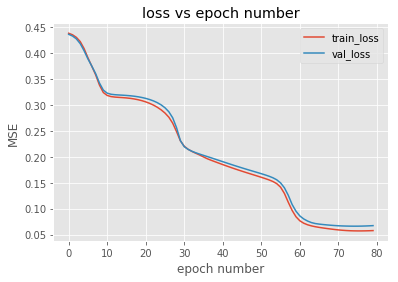

In [13]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [32]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:

Loss: 

0.217733649196

Accuracy: 

0.5854591836734694

Loss: 

0.216936321842

Accuracy: 

0.5892857142857143

Loss: 

0.215749892432

Accuracy: 

0.5931122448979592

Loss: 

0.214178013113

Accuracy: 

0.5969387755102041

Loss: 

0.212225724998

Accuracy: 

0.6007653061224489

Loss: 

0.209899656415

Accuracy: 

0.6020408163265306

Loss: 

0.207208268231

Accuracy: 

0.610969387755102

Loss: 

0.204162132515

Accuracy: 

0.6160714285714286

Loss: 

0.200774244463

Accuracy: 

0.6147959183673469

Loss: 

0.197060329782

Accuracy: 

0.6211734693877551

Loss: 

0.193039154345

Accuracy: 

0.6262755102040817

Loss: 

0.188732744025

Accuracy: 

0.6403061224489796

Loss: 

0.184166512666

Accuracy: 

0.6517857142857143

Loss: 

0.179369228107

Accuracy: 

0.6683673469387755

Loss: 

0.174372800889

Accuracy: 

0.673469387755102

Loss: 

0.16921192575

Accuracy: 

0.6798469387755102

Loss: 

0.163923599515

Accuracy: 

0.6989795918367347

Loss: 

0.158546584754

Accuracy: 

0.7219387755102041

Loss: 

0.153120904542

Accuracy: 

0.7423469387755102

Loss: 

0.147687396235

Accuracy: 

0.7551020408163265

Loss: 

0.142287249299

Accuracy: 

0.7691326530612245

Loss: 

0.136961435947

Accuracy: 

0.7933673469387755

Loss: 

0.131749908041

Accuracy: 

0.8188775510204082

Loss: 

0.126690680811

Accuracy: 

0.8456632653061225

Loss: 

0.121818686818

Accuracy: 

0.860969387755102

Loss: 

0.11716478601

Accuracy: 

0.8737244897959183

Loss: 

0.112754787119

Accuracy: 

0.8877551020408163

Loss: 

0.108608347159

Accuracy: 

0.8915816326530612

Loss: 

0.104738012555

Accuracy: 

0.8992346938775511

Loss: 

0.101147701476

Accuracy: 

0.9005102040816326

Loss: 

0.097833161103

Accuracy: 

0.9005102040816326

Loss: 

0.0947834305742

Accuracy: 

0.8992346938775511

Loss: 

0.0919833437127

Accuracy: 

0.9030612244897959

Loss: 

0.0894155552828

Accuracy: 

0.9043367346938775

Loss: 

0.0870614809808

Accuracy: 

0.9043367346938775

Loss: 

0.0849008588211

Accuracy: 

0.9030612244897959

Loss: 

0.0829102680283

Accuracy: 

0.9094387755102041

Loss: 

0.0810614509405

Accuracy: 

0.9068877551020408

Loss: 

0.0793195648402

Accuracy: 

0.9068877551020408

Loss: 

0.0776423668789

Accuracy: 

0.9056122448979592

Loss: 

0.0759824352316

Accuracy: 

0.9056122448979592

Loss: 

0.0742974210501

Accuracy: 

0.9056122448979592

Loss: 

0.0725757539844

Accuracy: 

0.9068877551020408

Loss: 

0.0708738525046

Accuracy: 

0.9094387755102041

Loss: 

0.0693209719959

Accuracy: 

0.9145408163265306

Loss: 

0.0680373277754

Accuracy: 

0.9145408163265306

Loss: 

0.067036800038

Accuracy: 

0.9158163265306123

Loss: 

0.0662457905184

Accuracy: 

0.9132653061224489

Loss: 

0.0655848700998

Accuracy: 

0.9145408163265306

Loss: 

0.0650047056932

Accuracy: 

0.9132653061224489

Loss: 

0.0644799168374

Accuracy: 

0.9145408163265306

Loss: 

0.0639966141939

Accuracy: 

0.9145408163265306

Loss: 

0.063545492209

Accuracy: 

0.9145408163265306

Loss: 

0.063119222081

Accuracy: 

0.9145408163265306

Loss: 

0.0627116213125

Accuracy: 

0.9158163265306123

Loss: 

0.062317429423

Accuracy: 

0.9158163265306123

Loss: 

0.0619323338657

Accuracy: 

0.9170918367346939

Loss: 

0.0615528928647

Accuracy: 

0.9170918367346939

Loss: 

0.0611765251473

Accuracy: 

0.9196428571428571

Loss: 

0.0608014722175

Accuracy: 

0.9209183673469388

Loss: 

0.0604267120998

Accuracy: 

0.9221938775510204

Loss: 

0.0600518535818

Accuracy: 

0.9209183673469388

Loss: 

0.0596770594108

Accuracy: 

0.9209183673469388

Loss: 

0.0593029159388

Accuracy: 

0.9209183673469388

Loss: 

0.0589302932796

Accuracy: 

0.9221938775510204

Loss: 

0.0585602638975

Accuracy: 

0.9221938775510204

Loss: 

0.0581940069029

Accuracy: 

0.923469387755102

Loss: 

0.0578327089882

Accuracy: 

0.923469387755102

Loss: 

0.0574775165387

Accuracy: 

0.923469387755102

Loss: 

0.0571294923135

Accuracy: 

0.923469387755102

Loss: 

0.0567895778475

Accuracy: 

0.9260204081632653

Loss: 

0.0564585743995

Accuracy: 

0.9260204081632653

Loss: 

0.0561371499435

Accuracy: 

0.9260204081632653

Loss: 

0.0558258522424

Accuracy: 

0.9260204081632653

Loss: 

0.0555251552809

Accuracy: 

0.9247448979591837

Loss: 

0.0552353838668

Accuracy: 

0.9247448979591837

Loss: 

0.0549567761072

Accuracy: 

0.9247448979591837

Loss: 

0.0546894908153

Accuracy: 

0.9247448979591837

Loss: 

0.054433609674

Accuracy: 

0.9272959183673469

Loss: 

0.0541891484833

Accuracy: 

0.9272959183673469

In [33]:
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss: 

0.0135681554627

Accuracy: 

0.9890804395913065


Precision: 0.09843400447427293

Recall: 0.88

F-score: 0.17706237424547283

             actual 1  actual 0
predicted 1        88       806
predicted 0        12     56056

In [ ]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)
